**Crisis Prediction**

Crisis can happen by the cause of many factors. This notebook will demonstrate an approach on how to measure the effect each of the dataset's factors (or variables) has towards economic crisis occurrence using data science. 

# Importing Packages and Data

First let's import all the important the libraries that will be used in this notebook

In [145]:
import numpy as np
import pandas as pd 
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.pyplot as plt
%matplotlib inline

In [146]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.metrics import auc, plot_roc_curve, classification_report, confusion_matrix, accuracy_score, make_scorer, roc_curve, roc_auc_score, log_loss, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree

# Data Preparation 

In [148]:
train_data.shape

(353, 14)

The train_data data set contains 353 rows, and 14 columns. 12 columns contain predictors that might have effect towards economic crisis occurrence The other 2 columns are: "Id"and "Krisis"(dependent variable).

In [149]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Id                                      353 non-null    int64  
 1   Ekspor                                  353 non-null    float64
 2   Cadangan Devisa                         353 non-null    float64
 3   IHSG                                    353 non-null    float64
 4   Rasio Suku Bunga Pinjaman/Simpanan      353 non-null    float64
 5   Suku Bunga Simpanan Riil                353 non-null    float64
 6   Selisih BI Rate Riil dan FED Rate Riil  353 non-null    float64
 7   Simpanan bank                           353 non-null    float64
 8   Nilai Tukar Riil                        353 non-null    float64
 9   Nilai Tukar Perdagangan                 353 non-null    float64
 10  M1                                      353 non-null    float6

We will first change some typos in the Independent Variable. The Dependent variable are in Krisis Column where the value are '1' and '0'. Where 1 is when the Crisis Happened

In [147]:
# train_data
train_data = pd.read_csv('data.csv', sep=',')
train_data.rename(columns={"Selisih Pinjaman dan Simpanan": "Rasio Suku Bunga Pinjaman/Simpanan"}, inplace=True)
train_data.rename(columns={"Simpanan bank ": "Simpanan bank"}, inplace=True)
train_data.head()

,Id,Ekspor,Cadangan Devisa,IHSG,Rasio Suku Bunga Pinjaman/Simpanan,Suku Bunga Simpanan Riil,Selisih BI Rate Riil dan FED Rate Riil,Simpanan bank,Nilai Tukar Riil,Nilai Tukar Perdagangan,M1,M2/Cadangan Devisa,M2M,Krisis
0,0,1845.2,6068.2,504.27,1.24,15.56,4.36,14.567329,376.63,1.2366,10.66,0.0055,6.46,1
1,1,2055.0,6259.1,612.20,1.24,16.63,5.83,16.707625,375.39,1.2129,12.15,0.0056,6.16,1
2,2,1803.0,5914.1,638.79,1.26,14.73,3.92,15.655003,380.27,1.6888,12.27,0.0062,5.78,1
3,3,1802.0,5259.7,636.40,1.23,15.13,4.32,15.321895,384.14,1.0033,11.56,0.0071,6.92,1
4,4,1750.0,5767.5,624.33,1.22,14.77,7.92,16.067787,388.69,1.0374,12.58,0.0066,6.77,0


## Adding some Features

We could use the theory of economics to expand the variables. By this way, we can later feed the machine learning algorithm with more useful information that can determine whether a condition is classified as crisis or not. This theory are based on research and little knowledge we had on economy feature

From variable Ekspor and Nilai Tukar Perdagangan we can obtain Impor, by:
- **Impor** = Ekspor / Nilai Tukar Perdagangan


From variable 'M2/Cadangan Devisa' we can obtain M2, by:
- **M2** = (M2/Cadangan Devisa) x Cadangan Devisa
    
    
From variable M2 and M2M we can obtain M0, by:
- **M0** = M2 / M2M

In [150]:
# feature expansion train_data
train_df_v2 = train_data.copy()

train_df_v2['Impor'] = train_df_v2['Ekspor']/train_df_v2['Nilai Tukar Perdagangan']

train_df_v2['M2'] = train_df_v2['M2/Cadangan Devisa'] * train_df_v2['Cadangan Devisa']

train_df_v2['M0'] = train_df_v2['M2'] / train_df_v2['M2M']

train_df = train_df_v2.copy()

## Checking for Duplicates and Missing Values

The train_data data set does not contain duplicated data.

In [153]:
# check if the train dataset contains duplicated data
train_df.duplicated().sum()

0

In [154]:
plt.rcParams['patch.force_edgecolor']=True
plt.rcParams['axes.grid']=True

The train_data data set does not contain data with missing value. 

In [155]:
krisis_vals = pd.DataFrame(data=train_df['Krisis'].value_counts())
krisis_vals = krisis_vals.reset_index()
krisis_vals['index'] = krisis_vals['index'].apply(lambda x : 'Not Crisis' if x == 0 else 'Crisis')
krisis_vals.columns = ['Outcome', 'Counts (n)']
krisis_vals['Portion (%)'] = round(((krisis_vals['Counts (n)'] / len(train_df)) * 100), 2)
krisis_vals.set_index('Outcome', inplace=True)
krisis_vals

,Counts (n),Portion (%)
Outcome,,
Not Crisis,314,88.95
Crisis,39,11.05


## Visualisizing the Data

Text(0.5, 1.0, 'Counts of Not Crisis and Crisis Data')

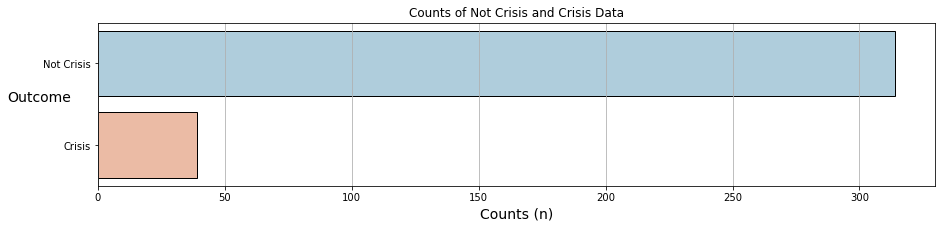

In [156]:
# sns.countplot(x='', data=krisis_vals.reset_index())
plt.figure(figsize=(15,3))
sns.barplot(x='Counts (n)', y='Outcome', data=krisis_vals.reset_index(), palette='RdBu_r')
plt.xlabel(xlabel = 'Counts (n)', fontsize=14)
plt.ylabel(ylabel = 'Outcome', fontsize=14, rotation=0)
plt.title('Counts of Not Crisis and Crisis Data')

Text(0.5, 1.0, 'Portion of Not Crisis and Crisis Data in Percentage')

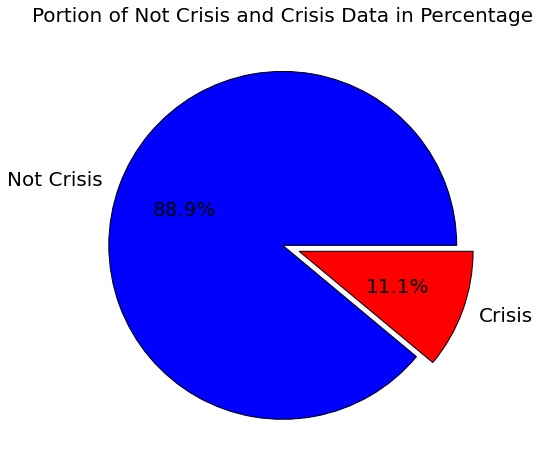

In [157]:
krisis_vals.iloc[:,1].plot.pie(autopct='%1.1f%%', shadow=False, startangle=0, figsize=(15,8), fontsize=20, explode=(0,0.1), colors=['blue','red'])
plt.ylabel(None)
plt.title('Portion of Not Crisis and Crisis Data in Percentage', fontsize=20)

The train_data data set is imbalanced. There are 88.9% of the train_data data set belongs to data with Not-crisis outcome, while the other 11.1% belongs to data with Crisis outcome. Some exploration that we can do are towards its scatterplot. from it we conclude that :

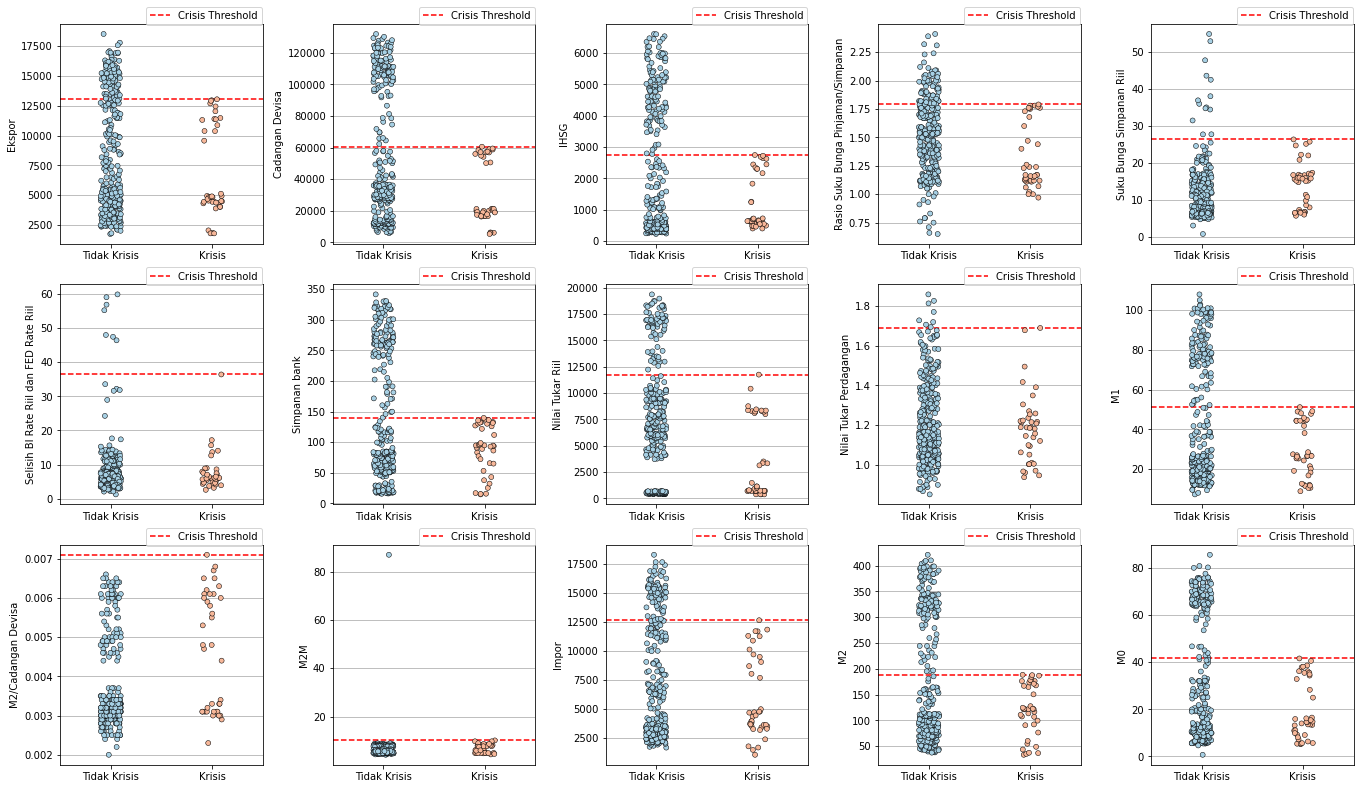

In [158]:
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(19,11))

lis_col = list(train_df.drop(['Id','Krisis'], axis=1).columns)
k = 0
for i in range(3):
  for j in range(5):
    sns.stripplot(x='Krisis', y=lis_col[k], data=train_df, dodge=True, palette='RdBu_r', orient='v', jitter=True, ax=axs[i,j], marker='o', edgecolor='black', linewidth=0.5)
    k+=1

o = 0
for m in range(3):
  for n in range(5):
    # plt.legend()
    axs[m,n].axhline(y=train_df[train_df['Krisis']==1][lis_col[o]].max(), color='red', ls='--', label='Crisis Threshold')
    axs[m,n].legend(loc='upper right',bbox_to_anchor=(1.02,1.1))
    axs[m,n].set_xlabel('')
    axs[m,n].set_xticklabels(['Tidak Krisis', 'Krisis'])
    o+=1

plt.tight_layout()

- Some variable have a crisis occurrence threshold. For example, Crisis does not occur when 'Simpanan bank' value is above 150.
- we hypothesize that M2/Cadangan Devisa and M2M are the macroeconomic indicators that have the least effect towards economic condition (crisis or not), because beside the outlier, other data points doesn't show any difference between krisis and non krisis

The histogram below shows the distribution of data with Crisis and Not-crisis outcome of each variable. Most of the variables' distributions hardly resemble normal distribution (or gaussian distribution), which makes it quite difficult to get insight from each variable.

Data Distribution of Each Variables (for each Crisis group)



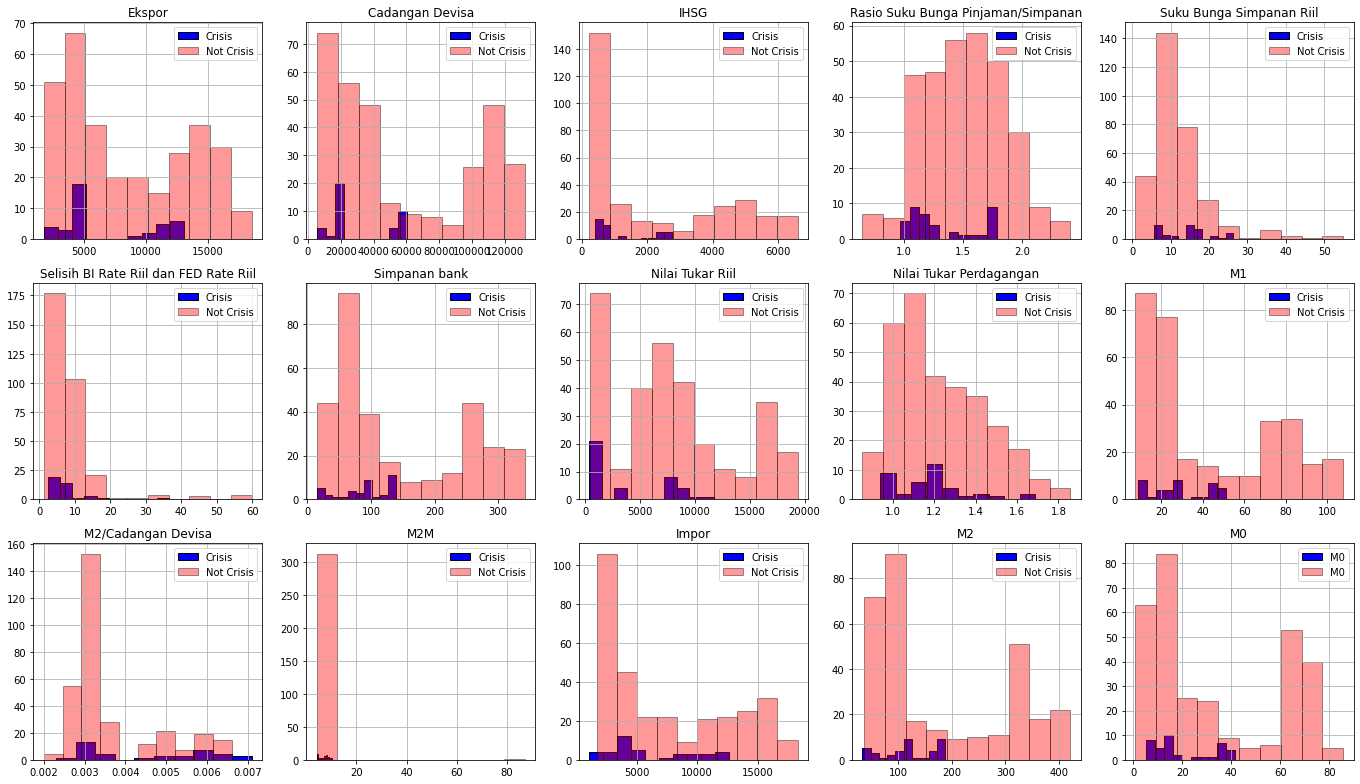

In [159]:
print('Data Distribution of Each Variables (for each Crisis group)')
print()
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(19,11))

lis_col = list(train_df.drop(['Id','Krisis'], axis=1).columns)

k = 0
for i in range(3):
  for j in range(5):
    axs[i,j].hist(x=lis_col[k], data=train_df[train_df['Krisis']==1], color='blue')
    axs[i,j].hist(x=lis_col[k], data=train_df[train_df['Krisis']==0], color='red', alpha=0.4)
    axs[i,j].legend(['Crisis', 'Not Crisis'], loc='best')
    axs[i,j].set_xlabel('')
    axs[i,j].set_title(lis_col[k])
    k+=1

plt.tight_layout()
plt.legend()

The boxplots below show the distributions of each variable in train_data data set, along with its outliers (if it has any).

- A Red Boxplot is a variable that contains outlier(s).
- A Green Boxplot is a variable that doesn't contain outlier(s).



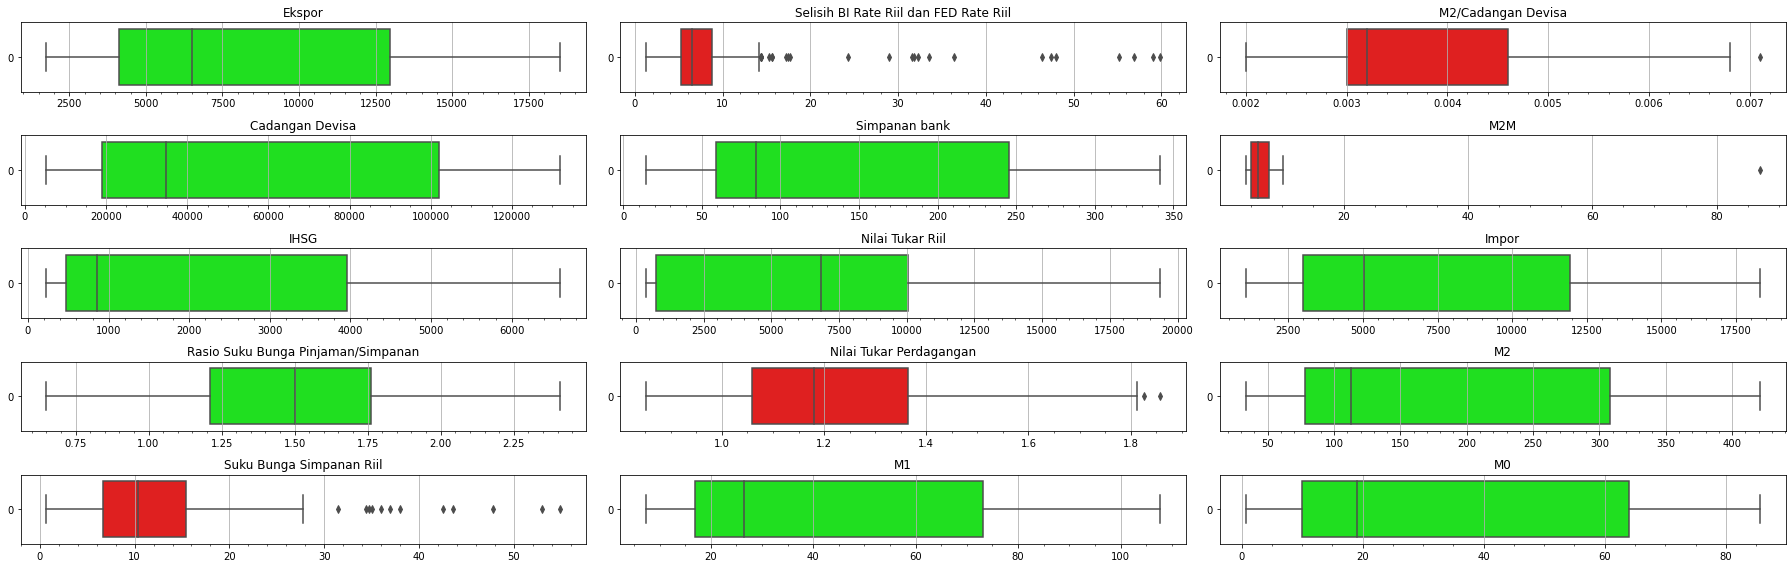

In [160]:
fig, axs = plt.subplots(ncols=3, nrows=5, figsize=(25,8))
 
lis_col = list(train_df.drop(['Id','Krisis'], axis=1).columns)
 
print("- A Red Boxplot is a variable that contains outlier(s).")
print("- A Green Boxplot is a variable that doesn't contain outlier(s).")
print()
 
k=0
for i in range(3):
  for j in range(5):
    Q1 = train_df[lis_col[k]].quantile(0.25)
    Q3 = train_df[lis_col[k]].quantile(0.75)
    IQR = Q3 - Q1
    outlier_lower_limit = Q1 - (1.5 * IQR)
    outlier_upper_limit = Q3 + (1.5 * IQR)
    count_outlier = 0
 
    for m in range(len(train_df)):
      if (train_df[lis_col[k]][m] > outlier_upper_limit) or (train_df[lis_col[k]][m] < outlier_lower_limit):
        count_outlier += 1
    
    if count_outlier > 0:
      sns.boxplot(data=train_df[lis_col[k]], color='red', orient='h', ax=axs[j,i])
    else:
      sns.boxplot(data=train_df[lis_col[k]], color='lime', orient='h', ax=axs[j,i])
 
    axs[j,i].set_title(lis_col[k])
    axs[j,i].xaxis.set_minor_locator(AutoMinorLocator())
    k+=1
    
 
plt.tight_layout()

We can create a dataframe using python's powerful library which is Pandas to get statistical description of each variable, such as mean, median, mode, IQR, and number of outliers.

In [161]:
lis_col = list(train_df.drop(['Id','Krisis'], axis=1).columns)

for i in range(len(lis_col)):
  if i == 0:
    outlier_df          = train_df[lis_col[i]].describe().transpose().reset_index()
    Q1                  = train_df[lis_col[i]].quantile(0.25)
    Q2                  = train_df[lis_col[i]].quantile(0.5)
    Q3                  = train_df[lis_col[i]].quantile(0.75)
    IQR                 = Q3 - Q1
    outlier_lower_bound = Q1 - (1.5 * IQR)
    outlier_upper_bound = Q3 + (1.5 * IQR)
    mode                = train_df[lis_col[i]].mode().values[0] # mode
    jml_outlier         = train_df[train_df[lis_col[i]]>outlier_upper_bound].sort_values(by=lis_col[i]).count().values[0] #jml outlier
    outlier_pct         = ((train_df[train_df[lis_col[i]]>outlier_upper_bound].sort_values(by=lis_col[i]).count().values[0]) / ((len(train_df)) )* 100) # persentase jml outlier terhadap total data (atau size variabel)

    data = {'index':['mode','outlier counts','outlier percentage (%)','outlier lower bound', 'outlier upper bound'], lis_col[i]:[mode,jml_outlier,outlier_pct,outlier_lower_bound,outlier_upper_bound]}
    data_df = pd.DataFrame(data=data)

    hasil = pd.concat([outlier_df, data_df], axis=0)

  else:
    outlier_data        = list(train_df[lis_col[i]].describe().transpose().reset_index()[lis_col[i]])
    Q1                  = train_df[lis_col[i]].quantile(0.25)
    Q2                  = train_df[lis_col[i]].quantile(0.5)
    Q3                  = train_df[lis_col[i]].quantile(0.75)
    IQR                 = Q3 - Q1
    outlier_lower_bound = Q1 - (1.5 * IQR)
    outlier_upper_bound = Q3 + (1.5 * IQR)
    mode                = train_df[lis_col[i]].mode().values[0] # mode
    outlier_data.append(mode)
    jml_outlier         = train_df[train_df[lis_col[i]]>outlier_upper_bound].sort_values(by=lis_col[i]).count().values[0] #jml outlier
    outlier_data.append(jml_outlier)
    outlier_pct         = ((train_df[train_df[lis_col[i]]>outlier_upper_bound].sort_values(by=lis_col[i]).count().values[0]) / ((len(train_df)) )* 100) # persentase jml outlier terhadap total data (atau size variabel)
    outlier_data.append(outlier_pct)

    outlier_data.append(outlier_lower_bound)
    outlier_data.append(outlier_upper_bound)

    hasil[lis_col[i]]   = outlier_data 
    

hasil.set_index('index', inplace=True)
hasil.index.names = ['']
hasil

,Ekspor,Cadangan Devisa,IHSG,Rasio Suku Bunga Pinjaman/Simpanan,Suku Bunga Simpanan Riil,Selisih BI Rate Riil dan FED Rate Riil,Simpanan bank,Nilai Tukar Riil,Nilai Tukar Perdagangan,M1,M2/Cadangan Devisa,M2M,Impor,M2,M0
,,,,,,,,,,,,,,,
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,8304.716714,53760.442125,2096.179688,1.493598,12.094533,8.547479,135.236670,7324.374816,1.221925,41.740057,0.003746,6.677450,7342.174865,174.026291,31.688783
std,4806.945143,41050.803337,2016.496845,0.333141,7.646845,7.879212,99.964335,5586.818360,0.211542,29.586100,0.001196,4.526645,5010.150642,118.458614,25.732484
min,1750.000000,5259.700000,226.680000,0.650000,0.680000,1.250000,14.567329,375.390000,0.851500,7.350000,0.002000,4.190000,1067.621980,33.375100,0.687617
25%,4136.000000,18985.000000,469.640000,1.210000,6.620000,5.210000,59.009300,729.860000,1.059000,16.860000,0.003000,5.040000,2997.689746,78.461600,10.018706
50%,6514.870000,34851.000000,860.350000,1.500000,10.390000,6.520000,84.781808,6830.610000,1.179300,26.460000,0.003200,6.120000,5045.391395,112.593488,19.128863
75%,12971.910000,102133.890000,3955.580000,1.760000,15.430000,8.800000,245.539787,10036.690000,1.363300,73.170000,0.004600,7.880000,11944.940182,307.696752,64.015306
max,18530.800000,131979.640000,6605.630000,2.410000,54.940000,59.880000,341.570999,19358.390000,1.857700,107.740000,0.007100,86.970000,18297.415730,420.999118,85.630407
mode,4027.000000,12207.200000,392.030000,1.120000,5.680000,3.530000,14.567329,375.390000,1.061200,12.070000,0.003100,5.190000,1067.621980,33.375100,0.687617


Multicollinearity analysis can be used if we want to know how each variable compared to another variables. High correlation might indicate that multicollinearity might exist (i.e. there might exist some kind of similarity between variables). Some machine learning algorithm (e.g. Logistic Regression), performs better if there is no multicollinearity. Multicollinearity analysis can be done using correlation analysis, or Variance Inflaction Factor analysis (VIF), which is the more common and accurate one.

The heatmap of variables' correlations suggest that there are high correlations between many variables. This might indicate that the train_data data set could have multicollinearity. To make sure of it, we will use VIF for second multicollinearity analysis.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5]),
 [Text(0.5, 0, 'Ekspor'),
  Text(1.5, 0, 'Cadangan Devisa'),
  Text(2.5, 0, 'IHSG'),
  Text(3.5, 0, 'Rasio Suku Bunga Pinjaman/Simpanan'),
  Text(4.5, 0, 'Suku Bunga Simpanan Riil'),
  Text(5.5, 0, 'Selisih BI Rate Riil dan FED Rate Riil'),
  Text(6.5, 0, 'Simpanan bank'),
  Text(7.5, 0, 'Nilai Tukar Riil'),
  Text(8.5, 0, 'Nilai Tukar Perdagangan'),
  Text(9.5, 0, 'M1'),
  Text(10.5, 0, 'M2/Cadangan Devisa'),
  Text(11.5, 0, 'M2M'),
  Text(12.5, 0, 'Krisis'),
  Text(13.5, 0, 'Impor'),
  Text(14.5, 0, 'M2'),
  Text(15.5, 0, 'M0')])

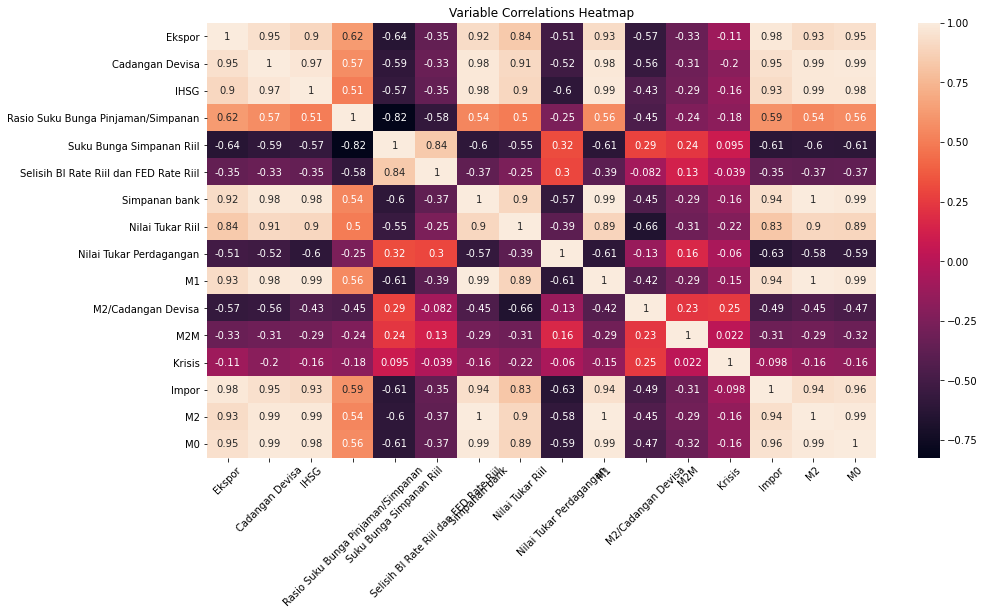

In [162]:
plt.figure(figsize=(15,8))
sns.heatmap(train_df.drop('Id', axis=1).corr(), annot=True)
plt.title('Variable Correlations Heatmap')
plt.xticks(rotation=45)

Multicollinearity Analysis Using VIF.

In [163]:
def calc_vif(predictor_cols):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = predictor_cols.columns
    vif["VIF"] = [variance_inflation_factor(predictor_cols.values, i) for i in range(predictor_cols.shape[1])]
    return(vif)

check_multicol = train_df.drop(['Id', 'Krisis'], axis=1)
data = calc_vif(check_multicol)
vif_df = pd.DataFrame(data=data)
vif_df.set_index('variables', inplace=True)
vif_df.sort_values(by='VIF', ascending=False, inplace=True)
vif_df

,VIF
variables,
M2,3291.151166
Simpanan bank,1481.329986
M1,668.209622
Cadangan Devisa,339.598402
M0,292.453952
Ekspor,261.995376
Impor,206.608800
IHSG,121.580754
Nilai Tukar Perdagangan,92.398072


Most variables have high VIF (if there's any variable with VIF more than 10, that means multicollinearity might exist in the data set). If we drop M2 variable, the VIF for each variable would drop, and if the VIF for each variable reaches below 10 after dropping a variable with the highest VIF, that means the multicollinearity does not exist any more in the train_data data set. But in this case, since we're not going to use machine learning algorithm that relies on data range or gradient descent technique, we will not drop any variables. 

Text(0.5, 1.0, 'Variance Inflation Factor (VIF) for Multicolinearity Analysis')

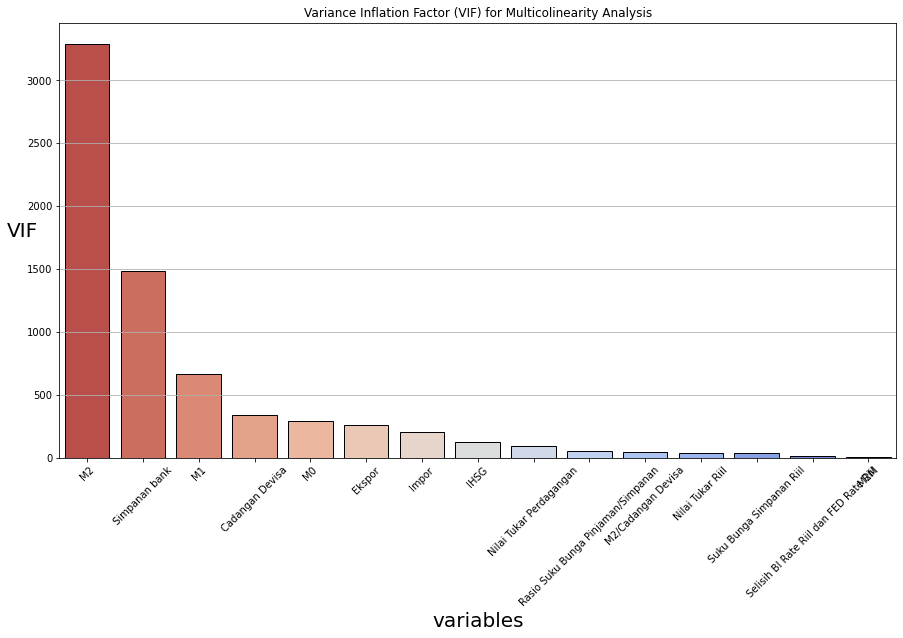

In [164]:
plt.figure(figsize=(15,8))
sns.barplot(x='variables',y='VIF',data=vif_df.reset_index(),palette='coolwarm_r')
plt.xticks(rotation=45)
plt.xlabel(xlabel = 'variables', fontsize=20)
plt.ylabel(ylabel = 'VIF', fontsize=20, rotation=0)
plt.title('Variance Inflation Factor (VIF) for Multicolinearity Analysis')

Multicollinearity analysis using correlation and VIF, and dropping the variables one-by-one starting from the highest VIF are necessary if we would want to use logistic regression or other machine learning algorithm that uses range between data points or gradient descent. However if we would want to use machine learning algorithm that doesn't use range between data points or gradient descent, we don't have to do multicollinearity analysis using correlation and VIF, and dropping variables one-by-one starting from the highest VIF. In this notebook we will use a more advance machine learning that is Random Forest, Random Forest doesn't affected by multicollinearity so we don't need to use VIF

## Data Preparation : Treating Outlier and SMOTE

By looking at boxplots of train_data variables we cannot ignore the outlier of M2M (of train_data), as the range between the outlier value and the upper bound is far too wide.

And because the outliers of 'Suku Bunga Simpanan Riil' and 'Selisih BI Rate Riil dan FED Rate Riil' in train_data data test quite resembles the outliers of those two variables in test_data data test, we assume they have natural outliers. And for that we will try to either ignore the outliers, or use binning technique (or discretization) to group the outlier. This is the method if we ever find natural outliers in a data set.

In [165]:
train_df2 = train_df.copy()

Text(0.5, 1.0, '"M2M" Boxplot')

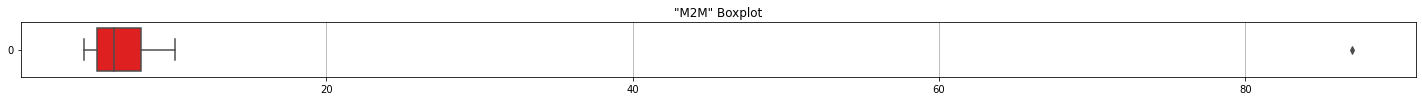

In [166]:
plt.figure(figsize=(25,1))

Q1 = train_df['M2M'].quantile(0.25)
Q3 = train_df['M2M'].quantile(0.75)
IQR = Q3 - Q1
outlier_lower_limit = Q1 - (1.5 * IQR)
outlier_upper_limit = Q3 + (1.5 * IQR)
count_outlier = 0
 
for m in range(len(train_df)):
  if (train_df['M2M'][m] > outlier_upper_limit) or (train_df['M2M'][m] < outlier_lower_limit):
    count_outlier += 1
    
if count_outlier > 0:
  sns.boxplot(data=train_df['M2M'], color='red', orient='h')
else:
  sns.boxplot(data=train_df['M2M'], color='lime', orient='h')
plt.title('"M2M" Boxplot')

In [167]:
# Mengganti nilai outlier dengan upper bound
for i in range(len(train_df)):
  if train_df['M2M'][i] > M2M.values[-1][0]:
    train_df['M2M'][i] = M2M.values[-1][0]

<ipython-input-167-1e1bdd16997a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['M2M'][i] = M2M.values[-1][0]


outlier values: []



Text(0.5, 1.0, '"M2M" Boxplot')

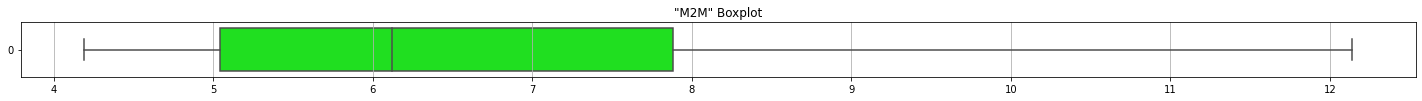

In [168]:
lis_coba = []

for i in train_df['M2M']:
  if i > M2M.values[-1][0]:
    lis_coba.append(i)
    
print('outlier values:',lis_coba)
print()
plt.figure(figsize=(25,1))

count_outlier = 0
 
for m in range(len(train_df)):
  if (train_df['M2M'][m] > M2M.values[-1][0]) or (train_df['M2M'][m] < M2M.values[-2][0]):
    count_outlier += 1
    
if count_outlier > 0:
  sns.boxplot(data=train_df['M2M'], color='red', orient='h')
else:
  sns.boxplot(data=train_df['M2M'], color='lime', orient='h')

plt.title('"M2M" Boxplot')

In [169]:
# We create train_df3 as a new dataframe. train_df3 will be the train_data data set after outlier treatment on M2M variable. 
train_df3 = train_df.copy()

## Smote for treating Imbalanced Data

In this notebook we will use SMOTE (Synthetic Minority Oversampling Technique) to balance the data set. SMOTE is an oversampling technique that can increase the number of minority data based on the pattern of the available minority data using K-nearest neighbors algorithm.

In [170]:
X = train_df3.drop(['Id', 'Krisis'], axis=1)
y = train_df3['Krisis']

In [171]:
X = train_df.drop(['Id', 'Krisis'], axis=1)
y = train_df['Krisis']

We need to feed the X_train (which is the train split side of the train_data) only to the SMOTE algorithm. We must not feed the X_test (which is the test split side of the train_data) to the SMOTE algorithm. This is because we want to have a very pure machine learning predictive model evaluation later.

The size of Crisis data number is very small, which is only 30 data. So we decide to feed 20 data to SMOTE algorithm, and use the other 10 data for y_test (for model evaluation later).

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=14)
print('Train Data Before SMOTE')
print('-----------------------------------')
print('Positive amounts :',len(np.where(y_train == 1)[0]))
print('Negative amounts :',len(np.where(y_train == 0)[0]))

Train Data Before SMOTE
-----------------------------------
Positive amounts : 27
Negative amounts : 237


In [173]:
print('Test Data')
print('-----------------------------------')
print('Positive amounts :',len(np.where(y_test == 1)[0]))
print('Negative amounts :',len(np.where(y_test == 0)[0]))

Test Data
-----------------------------------
Positive amounts : 12
Negative amounts : 77


Scaling is important before feeding the data into SMOTE algorithm. As SMOTE algorithm relies on KNN algorithm which depends on data range method approach to find data pattern and to create synthetic data which resembles real data.

In [174]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [175]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=3,random_state=421)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Train Data After SMOTE')
print('-----------------------------------')
print('Positive amounts :',len(np.where(y_res == 1)[0]))
print('Negative amounts :',len(np.where(y_res == 0)[0]))
print()

Train Data After SMOTE
-----------------------------------
Positive amounts : 237
Negative amounts : 237



In [176]:
print('X_res.shape:',X_res.shape)
print()
print('y_res.shape:',y_res.shape)

X_res.shape: (474, 15)

y_res.shape: (474,)


# Machine Learning Models

## Random Forest

To create the predictive model, we use RandomForest algorithm, which is basically a DecisionTree algorithm, except RandomForest is built using more than one tree to build the predictive model. That makes the RandomForest algorithm usually better at creating a good predictive model. However sometimes we can use DecisionTree if we are limited in computer computational power or when we want to check whether the model created using RandomForest algorithm is over-fit or not.

n_estimators=500 means we're using 500 trees. And n_jobs=-1 means we use all CPU for computation process.

In [177]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=14)
rf.fit(X_res, y_res)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=14)

- False Negatives are data that actually have positive values, but incorrectly classified or predicted as negatives.
- While False Positives are data that actually have negative values, but incorrectly classified or predicted as positives.
- The model is very good at avoiding false-negative predictions (precision 0 = 0.99) and false-positive predictions (precision 1 = 1).
- The model seems perfect at predicting positive values (Crisis) (recall 1 = 1.00). And it performs well at predicting negative values (Not-crisis) (recall 0 = 0.92).
- This quite makes sense, since basically the original train_data data set (before balanced using SMOTE) contains much more data with negative outcomes, than data with positive outcomes.

In [178]:
predictions_rf = rf.predict(X_test)
print(classification_report(y_test, predictions_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        77
           1       1.00      0.92      0.96        12

    accuracy                           0.99        89
   macro avg       0.99      0.96      0.98        89
weighted avg       0.99      0.99      0.99        89



ROC_AUC curve below shows that the model performs really well in every threshold (set automatically by the roc_auc algorithm, and threshold in RandomForestClassifier algorithm is number of trees). ROC_AUC curve is used when we want to check whether our model is over-fit or not. ROC_AUC curve's x-axis belongs to False Positive Rate, while the y-axis belongs to True Positive Rate. The area of the curve is called ROC_AUC, the closer the ROC_AUC to 1.00, the better the model at avoiding False Positive and False Negative.

No Skill: ROC AUC = 0.500
RandomForest Classifier: ROC AUC = 1.000



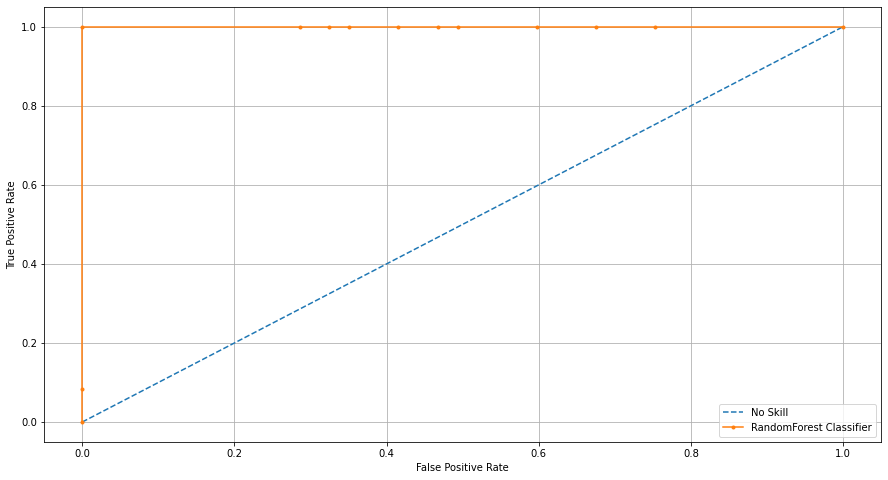

In [179]:
plt.rcParams['axes.grid']=True

rf_probs = rf.predict_proba(X_test)
rf_probs = rf_probs[:,1]
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
print('No Skill: ROC AUC = %.3f' % (ns_auc))
print('RandomForest Classifier: ROC AUC = %.3f' % (rf_auc))
print()
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
# plot the roc curve for the model
plt.figure(figsize=(15,8))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='RandomForest Classifier')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()

We can also combine cross-validation and the ROC_AUC curve in order to step-up the level of model's over-fit test. Basically the curve below consists of ROC_AUC curve from different fold of train_data data set. When we use train_test_split method, it means we are going to train the data from only one fold of train_data data set, this way we cannot check whether the model is over-fit or not.

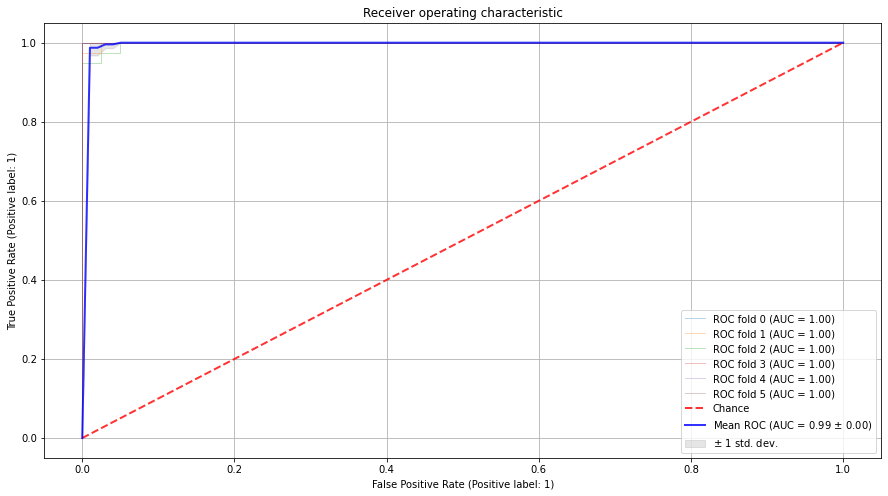

In [180]:
model = RandomForestClassifier(n_estimators=500, n_jobs=-1)
cv = StratifiedKFold(n_splits=6)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(15,8))
for i, (train, test) in enumerate(cv.split(X_res, y_res)):
    model.fit(X_res[train], y_res[train])
    viz = plot_roc_curve(model, X_res[test], y_res[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
plt.show()

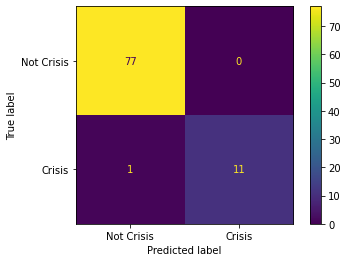

In [181]:
plt.rcParams['axes.grid']=False
plot_confusion_matrix(rf,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['Not Crisis', 'Crisis'])

We've got a model with good performance. Which means, now we can use it to predict the outcome of test_data at Kaggle.

RandomForestClassifier of Sci-kit Learn provides feature_importances_ feature that can show us the importance level of each variable. This can be used as measurement of the effect each of the data set's factors (or variables) has towards economic crisis occurrence. However it's better to also compare the feature_importances_ result with the theories of economics.

In [182]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Simpanan bank,0.127327
M2,0.123239
Cadangan Devisa,0.096766
Nilai Tukar Riil,0.083153
M1,0.082544
IHSG,0.067202
Impor,0.064739
Ekspor,0.058149
M0,0.054891
Nilai Tukar Perdagangan,0.052796


<AxesSubplot:xlabel='importance', ylabel='index'>

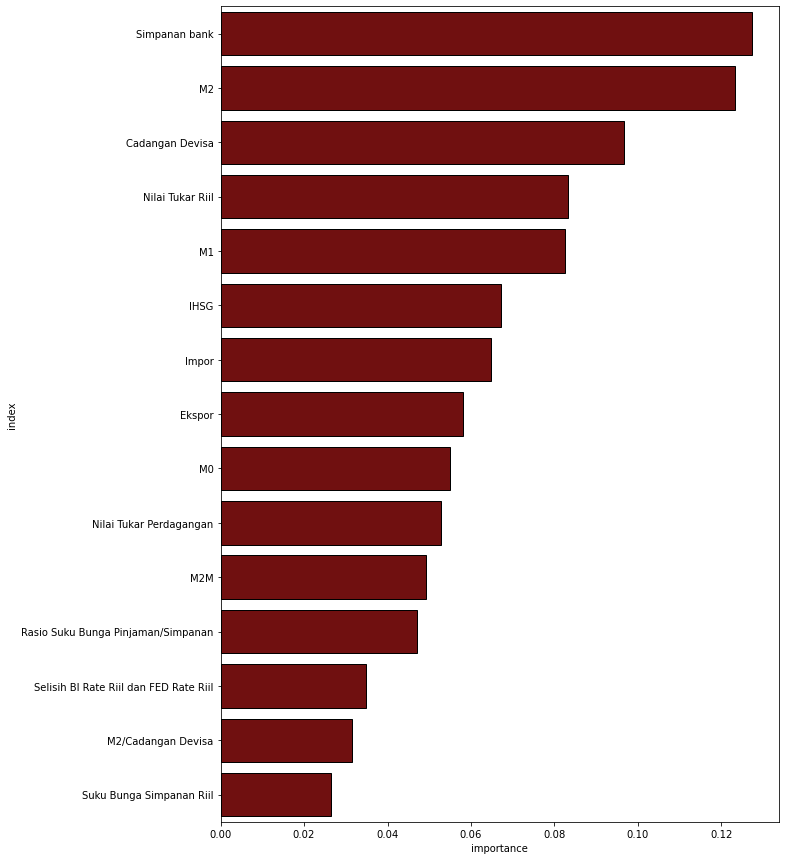

In [183]:
fig, ax = plt.subplots(1,1, figsize=(10,15))
sns.barplot(x='importance', y='index', color='#800000',data=feature_importances.reset_index())
# plt.xscale('log')

- The feature importance bar plot above shows the level of importance of each independent variable towards the dependent variable. Based on the plot above simpanan Bank have the greatest effect towards economic crisis occurrence. While the M2/Cadangan Devisa might have the lowest impact towards economic crisis occurence.
- We can also compare the feature importance and the threshold result, to get insight.

- We can get Crisis Threshold (and Crisis Tendency) insight based on the balanced data now, as the predictive model produced after training on the balanced data has a good performance on predicting new data. However If possible, it is still better to use the original data set and collect more crisis data.

- even though we have treated the outlier, the feature importances of M2/Cadangan Devisa and M2M suggest that they are the least important macroeconomic indicators that can affect economic condition (crisis or not). This prove that our hypothesis before are correct

- RandomForestClassifier is sci-kit learn's function that we can use to apply Random Forest machine learning algorithm for classification problem. Random forest itself is basically a decision tree. But since random forest use more than one tree, and in this case we used 500 trees, hence it is difficult to display all tree graphic results. 
- So for this, we're trying to do prediction again using decision tree. If the result matches with the result we got from random forest, then we can use the decision tree as another means to share data insight.

In [186]:
class_names = rf.classes_
class_names

array([0, 1], dtype=int64)

## Decision Tree

In [187]:
dt = DecisionTreeClassifier()
dt.fit(X_res, y_res)

DecisionTreeClassifier()

In [188]:
predictions_dt = dt.predict(X_test)
print(classification_report(y_test, predictions_dt))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        77
           1       0.80      0.67      0.73        12

    accuracy                           0.93        89
   macro avg       0.87      0.82      0.84        89
weighted avg       0.93      0.93      0.93        89



Since the result of decision tree's prediction is not as good as random forest's, we won't use predictive model created by the decision tree machine learning algorithm. A tree from random forest could be a representation from the random forest model. Please note that this tree cannot be a valid representation of the model, so its likely that the result diffrent from feature importance. This tree here is just to give a visualization of how a decision tree look like

Decision Tree


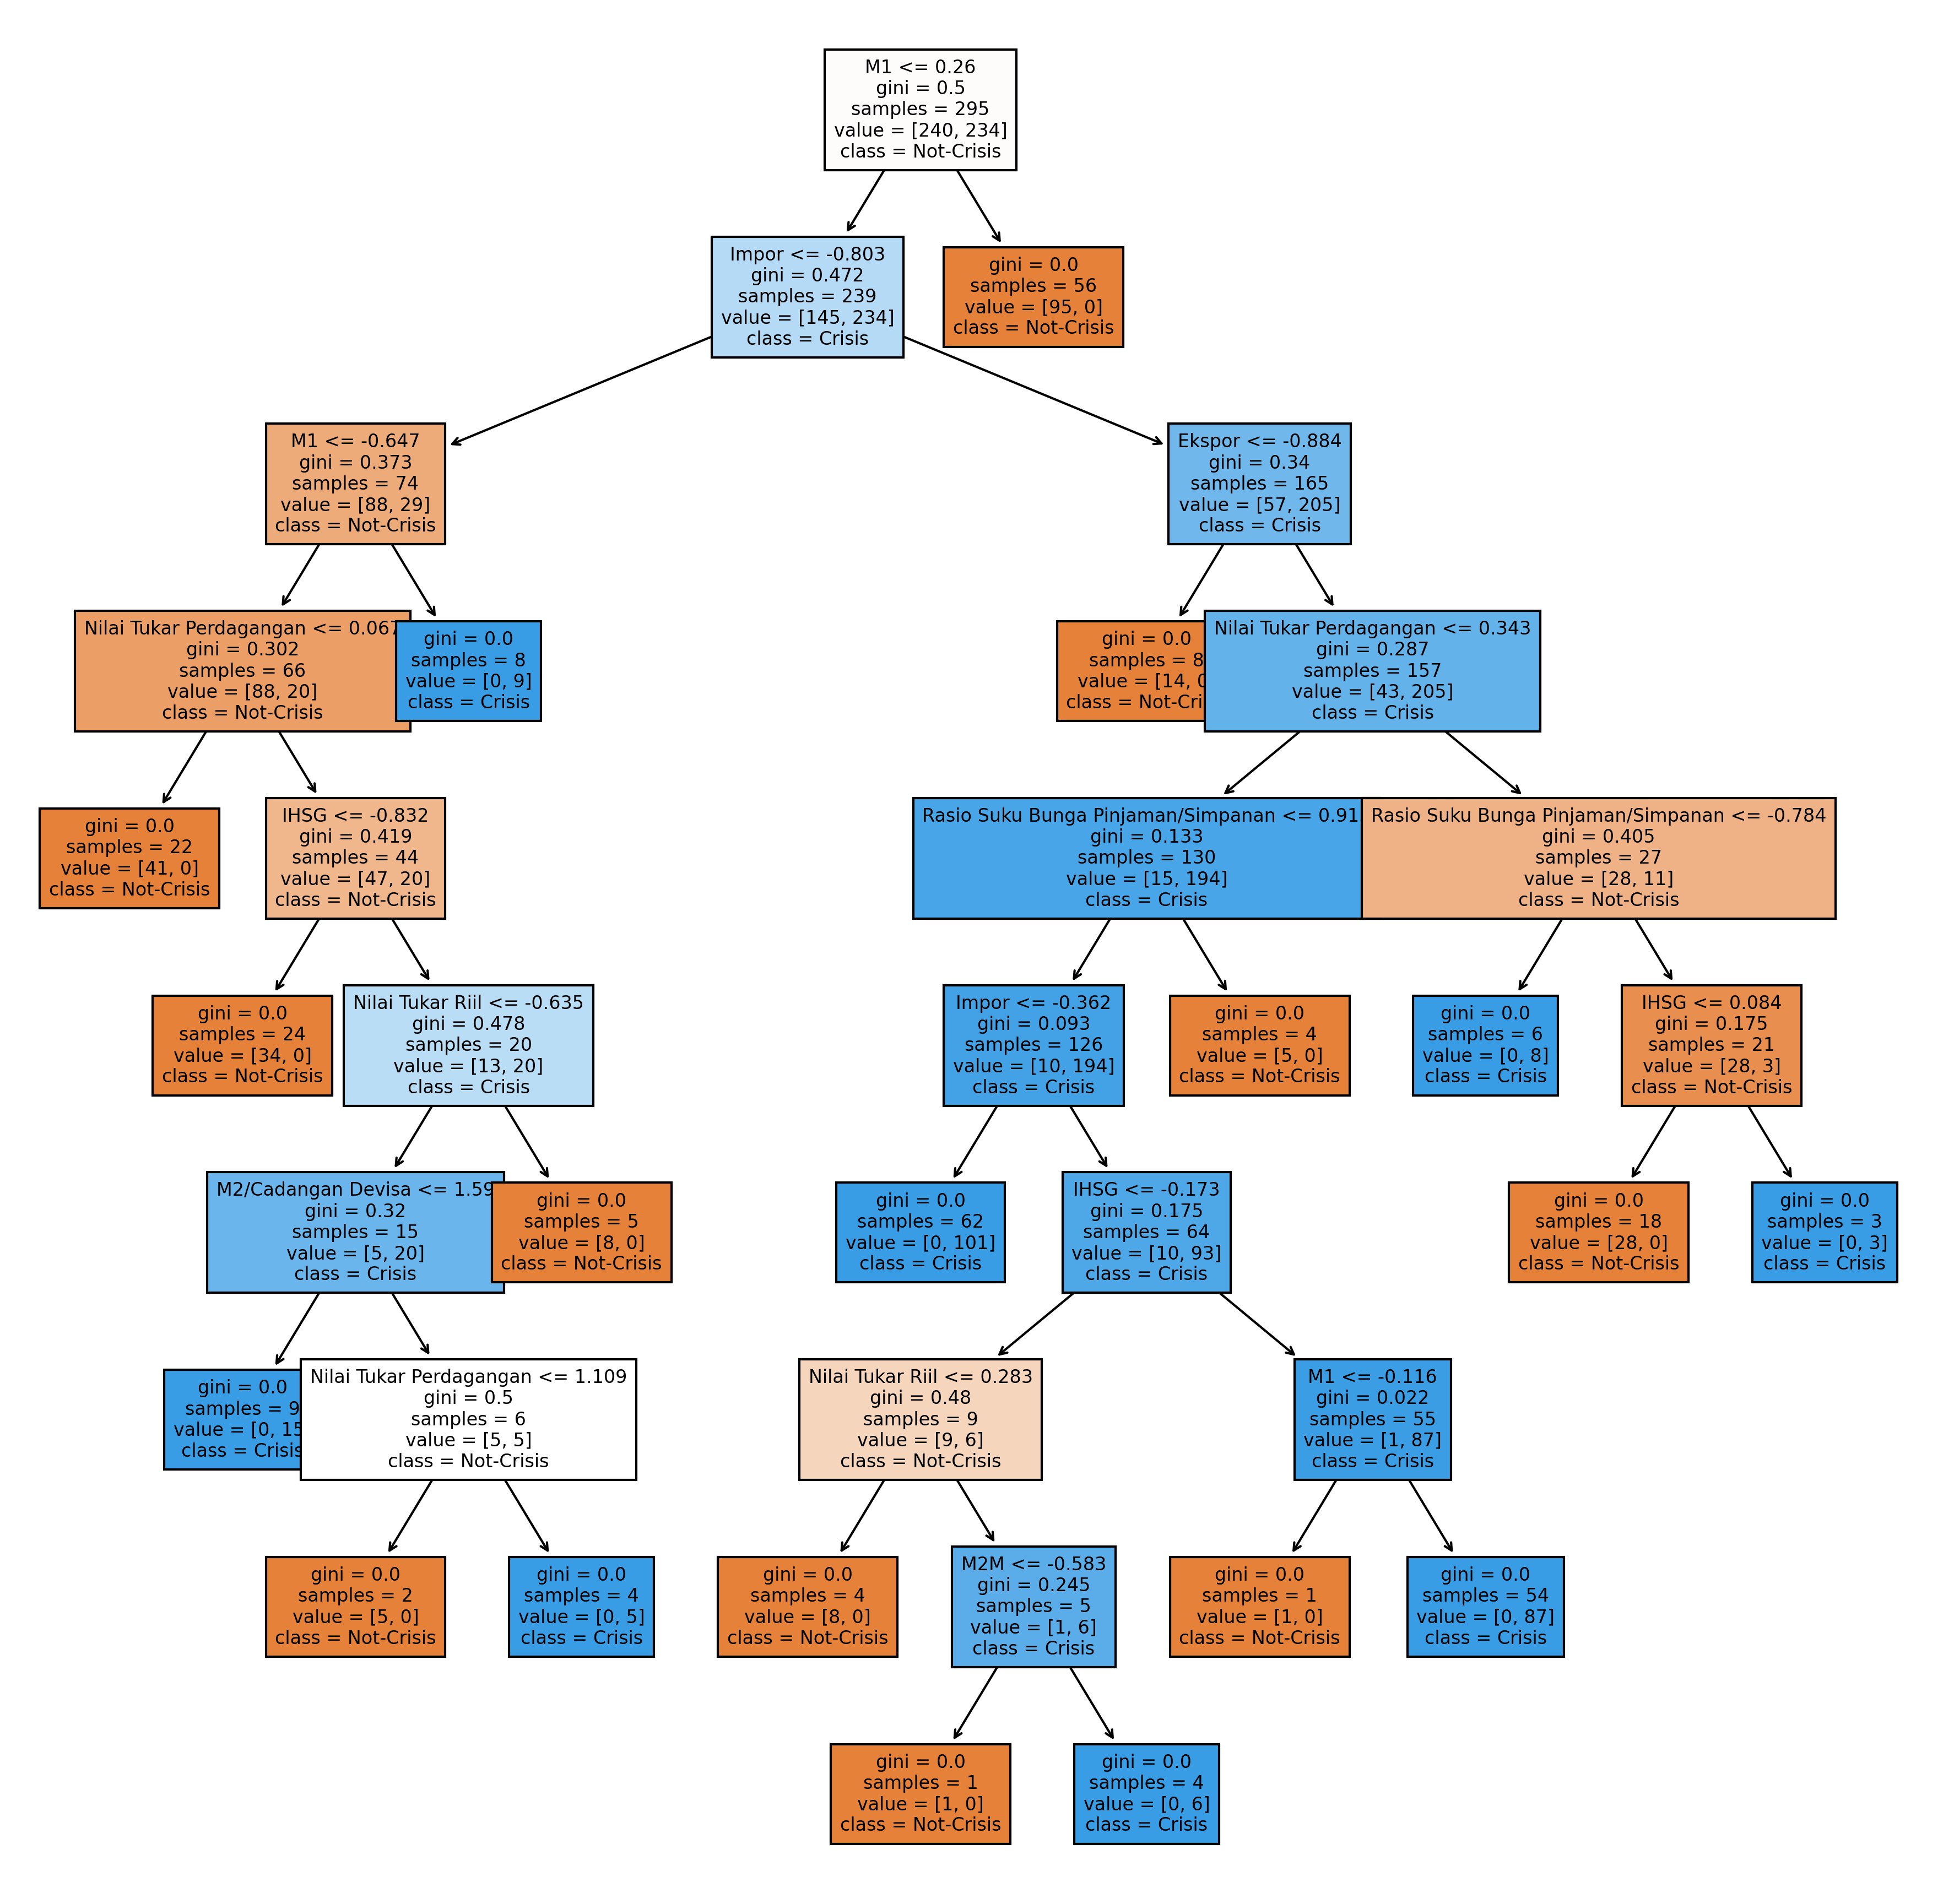

In [191]:
estimator = rf.estimators_[5]
fn=train_df2.drop(['Id','Krisis'], axis=1).columns
cn=True
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (15,15), dpi=300)
tree.plot_tree(estimator,
               feature_names = fn, 
               class_names=['Not-Crisis','Crisis'],
               filled = True,
               fontsize=8)
print('Decision Tree')